# Logistic Regression on Amazon Reviews Dataset (Part II)


## Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & cleaning.** The review text is now devoid of punctuations, HTML markups and stop words.

## Objective:
**To find optimal lambda using GridSearchCV & RandomSearchCV** on standardized feature vectors obtained from BoW, tf-idf, W2V and tf-idf weighted W2V featurizations. To study the impact on sparsity upon increasing lambda. 

**Find Precision, Recall, F1 Score, Confusion Matrix, Accuracy of 10-fold cross validation with GridSearch and RandomSearch with optimal Logistic Regression regression model on vectorized input data, for BoW, tf-idf, W2V and tf-idf weighted W2V featurizations.** TPR, TNR, FPR and FNR is calculated for all. 

After finding the optimal model, **do Perturbation test** to remove multicollinear features. **Find top n words** using the weight vector, w.


## At a glance:
Random Sampling is done to reduce input data size and time based slicing to split into training and testing data. **The optimal lambda is found out using GridSearchCV & RandomSearchCV with a range of lamda values to search (for GridSearch) and an uniform distribution (for RandomSearchCV.**

The Precision, Recall, F1 Score, Confusion Matrix, Accuracy metrics are found out for all 4 featurizations. A normal distribution noise is added for perturbnatino test and the identified multicollinear features are removed. Then the top 'n' words are found out after removal of multicollinear features based on highest values of |w|. <br><br>

# Preprocessed Data Loading

In [17]:
#loading libraries for LR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

#loading libraries for scikit learn, nlp, db, plot and matrix.
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(3))
print(final.shape)

    index      Id   ProductId          UserId            ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ... 



# Random Sampling & Time Based Slicing

In [18]:
# To randomly sample the data and sort based on time before doing train/ test split.
# The slicing into train & test data is done thereafter.

num_points = 20000

# used to format headings 
bold = '\033[1m'
end = '\033[0m'

# you can use random_state for reproducibility
sampled_final = final.sample(n=num_points, random_state=2)


#Sorting data according to Time in ascending order
sorted_final = sampled_final.sort_values('Time', axis=0, 
                ascending=True, inplace=False, kind='quicksort', na_position='last')

# fetching the outcome class 
y = sorted_final['Score'] 

def class2num(response):
    if (response == 'positive'):
        return 1
    else:
        return 0

y_bin = list(map(class2num, y))

X_train, X_test, y_train, y_test = train_test_split(
            sorted_final, y_bin, test_size=0.3, random_state=42)


# Custom Defined Functions

5 user defined functions are written to 

    a) Perform GridSearchCV & RandomSearchCV for Optimal Alpha Estimation.

    b) Compute Logistic Regression Classifier Performance Metrics.
    
    c) Find Most Frequent Words.
    
    d) Analyze Sparsity for increasing Lambda.
    
    e) Perturbation Test with a Normal Distributed Noise.
        

## a) GridSearchCV & RandomSearchCV for Optimal Alpha Estimation

In [19]:
# source: https://chrisalbon.com/machine_learning/
# model_selection/hyperparameter_tuning_using_random_search/
# some parts of the below code are from the above link.

# Cross Validation using RandomizedSearchCV & GridSearchCV

import numpy 
import math
from scipy.stats import uniform
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

def gridRandomCV(X_train_vect, X_test_vect, c_max, title_cf=''):
    
    # empty list that will hold cv scores
    cv_scores = []
    
    # Create regularization penalty space
    penalty = ['l1', 'l2']

    # Create regularization hyperparameter distribution using uniform distribution
    # This distribution is constant between loc and loc + scale.
    C = uniform(loc=0, scale=c_max)
    
    # Create hyperparameter options
    hyperparameters = dict(C=C, penalty=penalty)

    ###################################################################
    # Cross Validation using RandomizedSearchCV
    # Create randomized search 10-fold cross validation and 100 iterations
    model = RandomizedSearchCV(LogisticRegression(), hyperparameters, 
                    random_state=1, n_iter=100, cv=10, verbose=0, n_jobs=-1)
    
    # Fit randomized search
    best_model = model.fit(X_train_vect, y_train)
    
    best_regularizer = best_model.best_estimator_.get_params()['penalty']
    
    # View best hyperparameters
    print(bold + '\nBest Penalty:', best_regularizer)
    
    optimal_lambda_rcv = best_model.best_estimator_.get_params()['C']
    print('RandomizedSearchCV: Best C:', optimal_lambda_rcv, end, '\n')
    
    means = best_model.cv_results_['mean_test_score']
    stds = best_model.cv_results_['std_test_score']
    print ("Mean Test Score (+/-) Standard Deviation for Parameters: ")
    for mean, std, params in zip(
            means, stds, best_model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    print('\nThe optimal value of lambda using RandomizedSearchCV is %f.' 
                                                  % (1/optimal_lambda_rcv))
    
    compute_metrics(best_model, X_test_vect, 
                        title_cf="Confusion Matrix: RandomizedSearchCV")
    ###################################################################


    ###################################################################
    # Cross Validation using GridSearchCV
    inv_lambda_values = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 
                           10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
    
    tuned_parameters = [{'C': inv_lambda_values}, {'penalty': penalty}]
    
    model = GridSearchCV(LogisticRegression(), 
                         tuned_parameters, scoring = 'f1', cv=10)
    model.fit(X_train_vect, y_train)

    means = model.cv_results_['mean_test_score']
#     stds = model.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, model.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print(type(model.cv_results_['params']))
#     print(model.cv_results_['params'])
    
    # determining best lambda
    optimal_lambda_gcv = model.cv_results_['params'][means.argmax()].get('C')
    print('\nGridSearchCV: Best C:', optimal_lambda_gcv)
    print(
        '\nThe optimal value of lambda using GridSearchCV is %f.' 
                                                    % (1/optimal_lambda_gcv))
    
    compute_metrics(model, X_test_vect, title_cf="Confusion Matrix: GridSearchCV")
    ###################################################################
    
    return optimal_lambda_rcv, best_regularizer

## b) Compute Logistic Regression Classifier Performance Metrics

In [20]:
# ========================== LR with alpha = optimal_alpha ============================
#To compute the performance metrics of Logistic Regression classifier 

import seaborn as sn
from sklearn.metrics import *

def compute_metrics(logR_optimal, X_test_vect, title_cf="Confusion Matrix"):

    # predict the response
    pred = logR_optimal.predict(X_test_vect)

    print(bold + '\n\nMetric Analysis of Logistic Classifier for Optimal Lamdba' + end)
    
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nAccuracy \t= %f' % acc)
    
    precision = precision_score(y_test, pred) * 100
    print('Precision \t= %f' % precision)
    
    recall = recall_score(y_test, pred) * 100
    print('Recall \t\t= %f' % recall)
    
    f1score = f1_score(y_test, pred) * 100
    print('F1 Score \t= %f' % f1score)
    
    confusion = confusion_matrix(y_test, pred)
    print(bold + "\n\nConfusion Matrix" + end)
    
    plt.figure()
    plt.title(title_cf)
    df_cm = pd.DataFrame(confusion, range(2), range(2))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d")# font size
    
    (tn, fp, fn, tp) = confusion.ravel()
    print("\nTrue Negatives = " + str(tn))
    print("True Positives = " + str(tp))
    print("False Negatives = " + str(fn))
    print("False Positives = " + str(fp))
    
    actual_positives = tp+fn
    actual_negatives = tn+fp
    print("\nTotal Actual Positives = " + str(actual_positives))
    print("Total Actual Negatives = " + str(actual_negatives))
    
    print("\nTrue Positive Rate(TPR) = " + str(round(tp/actual_positives, 2)))
    print("True Negative Rate(TNR) = " + str(round(tn/actual_negatives, 2)))
    print("False Positive Rate(FPR) = " + str(round(fp/actual_negatives, 2)))
    print("False Negative Rate(FNR) = " + str(round(fn/actual_positives, 2)))
    

## c) Find Most Frequent Words

In [21]:
# To find out the out top words based on absolute values of w
# Exclusion of collinear features done using mask

from itertools import compress

def find_top_words(vect, weights, mask, nwords):
    
    # Sort the absolute value of weights
    weight_sorted = abs(weights).argsort()
    
    # Exclude the collinear features 
    features = vect.get_feature_names()
    features_masked = list(compress(features, list(~mask)))
    
    # find top words
    top_words = np.take(features_masked, 
                        weight_sorted[weight_sorted.size-nwords:])

    print(bold + "\n\nTop Words: "+ end)
    for id, word in enumerate(top_words):
        print("\t" + word + "\t\t Weight: " + str(
            round(weights[weight_sorted[weight_sorted.size-nwords+id]], 2)))


## d) Analyze Sparsity for increasing Lambda

In [22]:
# More Sparsity (i.e. fewer elements of W* being non-zero) 
# by increasing Lambda (decreasing C) 

def testL1_increaseLambda(X_train_vect, X_test_vect):
        
    # empty list that will hold values
    lamdas = []
    sparsities = []
    f1scores = []
    
    invlamda = 1000000
    
    print(bold + 
        '\n\nSparsity Analysis of L1 Regularizer for increasing Lambda' + end)
    
    # iterate to reach lowest value of invlamda
    while invlamda > 10**-2:
            
        clf = LogisticRegression(C=invlamda, penalty='l1')
        clf.fit(X_train_vect, y_train)
        w = clf.coef_

        pred = clf.predict(X_test_vect)
        f1score = f1_score(y_test, pred) * 100
        
        
        lamda = round(1/invlamda, 6)
        sparsity = round(np.count_nonzero(w))
        f1score = round(f1score, 2)
        
        lamdas.append(math.log(lamda, 10))
        sparsities.append(sparsity)
        f1scores.append(f1score)
        
        print(bold +"\nSparsity vs Performance: Lambda = " 
                                              + str(lamda) + end)
        print("Sparsity =" + str(sparsity))
        print("F1 Score =" + str(f1score))

        invlamda *= 10**-1

    plt.figure()
    plt.plot(lamdas, sparsities)
    plt.xlabel('Log (Lambda)')
    plt.ylabel('# of Non-Zero Elements')
    plt.title('Increasing Lambda: Sparsity Plot')
    
    plt.figure()
    plt.plot(lamdas, f1scores)
    plt.xlabel('Log (Lambda)')
    plt.ylabel('F1 Score')
    plt.title('Increasing Lambda: F1 Score Plot')

## e) Perturbation Test with a Normal Distributed Noise

Sparsity of input vector is preserved for BoW and tf-idf featurizations. For W2V and tf-idf W2V the features are dense.

In [23]:
# Perturbation Test after adding N(0, 0.01)

def doPertubationTest(X_train_vect, invLambda, regularizer, isSparse):
    
    clf = LogisticRegression(C=invLambda, penalty = regularizer)
    clf.fit(X_train_vect, y_train)
    w = clf.coef_
    w = w[0]
    print("\nLength of Weight Vector (Before Removing Collinearity): " 
                                                              + str(len(w)))
    
    # Generate epsilon = normal distribution with mean = 0 and std = 0.01
    epsilon = np.random.normal(loc=0.0, scale=0.01,size = X_train_vect.shape)
    
    # To add epsilon only to non-zero elements
    mask = X_train_vect != 0
    
    #if sparse matrix from bow or tfidf then convert to dense array
    if (isSparse):
        mask = mask.toarray()
    
    X_train_vect[mask] = (X_train_vect[mask].astype(float) + 
                        epsilon[mask].astype(float)).astype(float)

    # To calculate weight vector, w, after perturbation
    clf.fit(X_train_vect, y_train)
    w_pert = clf.coef_
    w_pert = w_pert[0]
    
    
    # To find the % change in weights per feature
    w_change = w_pert/w
    
    dist = numpy.linalg.norm(w-w_pert)
    print("Distance between Weight vectors before & after Perturbation  = " 
                                                      + str(round(dist,2)))
    
    # if the percent change > threshold then that feature is multicollinear
    percent_change = 0.05
    
    # Eliminate collinear features and return weight vector to find top features.
    mask = (w_change > 1+percent_change) | (w_change < 1-percent_change)
    
    print("Multicollinear Features = " + str((w_change[mask]).size))
    
    return w[~mask], mask


# BoW

BoW will result in a **sparse matrix with huge number of features** as it creates a feature for each unique word in the review.

For Binary BoW feature representation, CountVectorizer is declared as float, as the values can take non-integer values on further processing. Top n words are found out after checking for multicollinearity.



1) Grid Search and Random Search CV using Logistic Regression

Best Penalty: l1
RandomizedSearchCV: Best C: 0.1782075141790469  

Mean Test Score (+/-) Standard Deviation for Parameters: 
0.887 (+/-0.018) for {'C': 1.668088018810296, 'penalty': 'l1'}
0.870 (+/-0.017) for {'C': 3.730229437354635, 'penalty': 'l2'}
0.875 (+/-0.016) for {'C': 1.209330290527359, 'penalty': 'l2'}
0.876 (+/-0.016) for {'C': 0.9443559078079042, 'penalty': 'l2'}
0.877 (+/-0.016) for {'C': 0.7450408455106836, 'penalty': 'l2'}
0.871 (+/-0.016) for {'C': 2.67898414721392, 'penalty': 'l2'}
0.884 (+/-0.018) for {'C': 2.155266936013428, 'penalty': 'l1'}
0.888 (+/-0.018) for {'C': 1.2530940677291005, 'penalty': 'l1'}
0.891 (+/-0.019) for {'C': 0.8178089989260697, 'penalty': 'l1'}
0.891 (+/-0.019) for {'C': 0.9183088549193021, 'penalty': 'l1'}
0.871 (+/-0.016) for {'C': 2.681870040713609, 'penalty': 'l2'}
0.872 (+/-0.016) for {'C': 1.828819231947953, 'penalty': 'l2'}
0.893 (+/-0.015) for {'C': 0.5615477543809351, 'pe

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


Distance between Weight vectors before & after Perturbation  = 0.3
Multicollinear Features = 829

Length of Weight Vector (After Removing Collinearity): 14285


Top Words: 
	bit		 Weight: 0.35
	year		 Weight: 0.36
	enjoy		 Weight: 0.37
	favorit		 Weight: 0.4
	tasti		 Weight: 0.41
	product		 Weight: -0.43
	nice		 Weight: 0.47
	tast		 Weight: -0.47
	excel		 Weight: 0.48
	amaz		 Weight: 0.48
	easi		 Weight: 0.48
	return		 Weight: -0.48
	day		 Weight: 0.5
	disappoint		 Weight: -0.5
	delici		 Weight: 0.61
	perfect		 Weight: 0.68
	good		 Weight: 0.69
	best		 Weight: 0.87
	love		 Weight: 0.95
	great		 Weight: 1.19


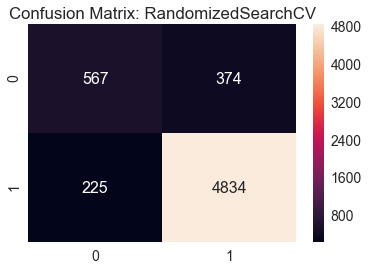

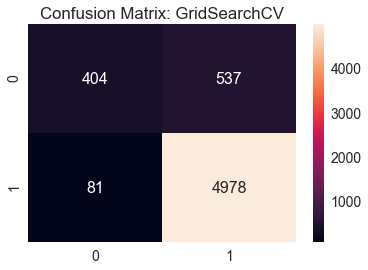

In [24]:
# BoW Featurisation, Standardisation, Grid Search and Random Search, 
# Impact of Sparsity on increasing lambda, Perturbation test to remove 
# multicollinear features, Find top n words using weight vector.

# from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import StandardScaler

#BoW
count_vect = CountVectorizer(dtype="float") #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

#BoW Test
X_test_vect = count_vect.transform(X_test['CleanedText'].values)

# Standardisation. Set "with_mean=False" to preserve sparsity
scaler = StandardScaler(copy=False, with_mean=False).fit(X_train_vect)
X_train_vect = scaler.transform(X_train_vect)
scaler = StandardScaler(copy=False, with_mean=False).fit(X_test_vect)
X_test_vect = scaler.transform(X_test_vect)

print(bold + "\n\n1) Grid Search and Random Search CV using Logistic Regression"+ end)

# Do both grid Search and Random Search. 
# The function returns optimal value of lambda
# sets the maximum value of C to be 4 for RandomCV
optimal_lambda, best_regularizer = gridRandomCV(X_train_vect, X_test_vect, 4)


# Do pertubation test to check multicollinearity. 
# Get weight vector after removing collinear features.
weights_non_collinear, mask = doPertubationTest(
                                X_train_vect, optimal_lambda, best_regularizer, True)

print("\nLength of Weight Vector (After Removing Collinearity): " 
                                      + str(len(weights_non_collinear)))

# To print top n=20 words
find_top_words(count_vect, weights_non_collinear, mask, 20) 


# Sparsity vs F1 score Plot

The variation of sparsity corresponding to varying values of lambda is plotted and the lambda with the highest accuracy is identified. The optimal model can be found out using the sparsity vs f1 score plot also.



Sparsity Analysis of L1 Regularizer for increasing Lambda

Sparsity vs Performance: Lambda = 1e-06
Sparsity =13034
F1 Score =91.2

Sparsity vs Performance: Lambda = 1e-05
Sparsity =10716
F1 Score =91.43

Sparsity vs Performance: Lambda = 0.0001
Sparsity =9482
F1 Score =91.42

Sparsity vs Performance: Lambda = 0.001
Sparsity =6441
F1 Score =92.13

Sparsity vs Performance: Lambda = 0.01
Sparsity =5353
F1 Score =92.88

Sparsity vs Performance: Lambda = 0.1
Sparsity =3926
F1 Score =93.27

Sparsity vs Performance: Lambda = 1.0
Sparsity =3637
F1 Score =93.63

Sparsity vs Performance: Lambda = 10.0
Sparsity =2891
F1 Score =94.24

Sparsity vs Performance: Lambda = 100.0
Sparsity =376
F1 Score =93.73


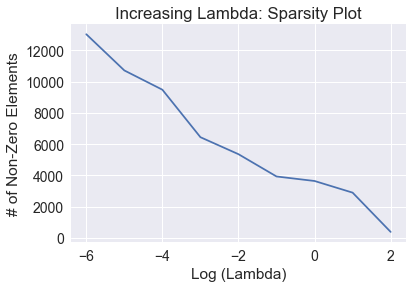

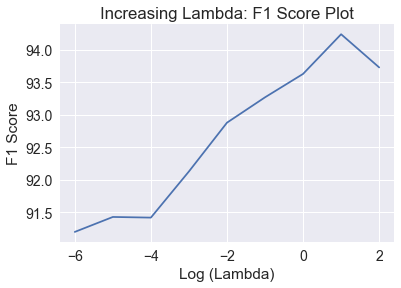

In [25]:

# To study the variation of sparsity vs f1 score for increasing values of lambda.
# here the train/ test vector is based on BoW featurization.
testL1_increaseLambda(X_train_vect, X_test_vect)

# Here Sparsity = # of non-zero elements.
# it is found that the number of zero elements increases as lambda is increased.

# tf-IDF 

**Sparse matrix generated from tf-IDF ** is fed in to GridSearch and RandomSearch Logistic Regression Cross Validator to find the optimal lambda value. Performance metrics of optimal LR with tf-idf featurization is found.



1) Grid Search and Random Search CV using Logistic Regression

Best Penalty: l1
RandomizedSearchCV: Best C: 445.51878544761723  

Mean Test Score (+/-) Standard Deviation for Parameters: 
0.852 (+/-0.013) for {'C': 4170.22004702574, 'penalty': 'l1'}
0.852 (+/-0.017) for {'C': 9325.573593386587, 'penalty': 'l2'}
0.852 (+/-0.017) for {'C': 3023.3257263183978, 'penalty': 'l2'}
0.852 (+/-0.018) for {'C': 2360.8897695197606, 'penalty': 'l2'}
0.852 (+/-0.017) for {'C': 1862.602113776709, 'penalty': 'l2'}
0.852 (+/-0.017) for {'C': 6697.4603680348, 'penalty': 'l2'}
0.849 (+/-0.013) for {'C': 5388.167340033569, 'penalty': 'l1'}
0.853 (+/-0.014) for {'C': 3132.735169322751, 'penalty': 'l1'}
0.854 (+/-0.010) for {'C': 2044.5224973151744, 'penalty': 'l1'}
0.852 (+/-0.015) for {'C': 2295.7721372982555, 'penalty': 'l1'}
0.852 (+/-0.017) for {'C': 6704.675101784022, 'penalty': 'l2'}
0.852 (+/-0.017) for {'C': 4572.048079869883, 'penalty': 'l2'}
0.855 (+/-0.013) for {'C': 1403.8693859523378, 'penal

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


Distance between Weight vectors before & after Perturbation  = 2.93
Multicollinear Features = 7557

Length of Weight Vector (After Removing Collinearity): 7557


Top Words: 
	right		 Weight: 0.61
	mellow		 Weight: 0.63
	worst		 Weight: -0.63
	delight		 Weight: 0.63
	delic		 Weight: 0.63
	definit		 Weight: 0.68
	complaint		 Weight: 0.68
	everyon		 Weight: 0.68
	easier		 Weight: 0.73
	often		 Weight: 0.74
	unhealthi		 Weight: 0.75
	threw		 Weight: -0.78
	wonder		 Weight: 0.83
	enjoy		 Weight: 0.95
	perfect		 Weight: 1.05
	excel		 Weight: 1.1
	good		 Weight: 1.16
	love		 Weight: 1.55
	best		 Weight: 1.8
	great		 Weight: 1.92


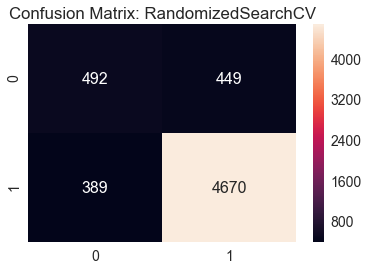

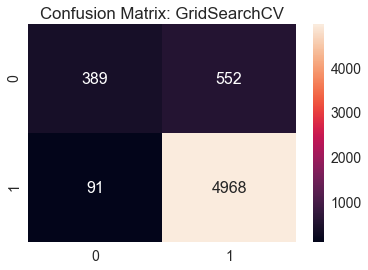

In [26]:
 
# TFID Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features, Find top n words.

from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import StandardScaler

# TFID
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

# TFID Test
X_test_vect = count_vect.transform(X_test['CleanedText'].values)

# Standardisation. Set "with_mean=False" to preserve sparsity
scaler = StandardScaler(copy=False, with_mean=False).fit(X_train_vect)
X_train_vect = scaler.transform(X_train_vect)
scaler = StandardScaler(copy=False, with_mean=False).fit(X_test_vect)
X_test_vect = scaler.transform(X_test_vect)

print(bold + "\n\n1) Grid Search and Random Search CV using Logistic Regression"+ end)

# Do both grid Search and Random Search. 
# The function returns optimal value of lambda
# sets the maximum value of C to be 10**4 for RandomCV
optimal_lambda, best_regularizer = gridRandomCV(X_train_vect, X_test_vect, 10**4)

# To check sparsity and f1 score for increasing values of lambda
# testL1_increaseLambda(X_train_vect, X_test_vect)

# Do pertubation test to check multicollinearity. 
# Get weight vector after removing collinear features.
weights_non_collinear, mask = doPertubationTest(
                                X_train_vect, optimal_lambda, best_regularizer, True)

print("\nLength of Weight Vector (After Removing Collinearity): " 
                                      + str(len(weights_non_collinear)))

# To print top n words
find_top_words(count_vect, weights_non_collinear, mask, 20)


# Word2Vec

**Dense matrix generated from Word2Vec ** is fed in to GridSearch and RandomSearch Logistic Regression Cross Validator to find the optimal lambda value. 

Performance metrics of optimal LR with W2V featurization is found. But we cannot find the top 'n' words when we use Word2Vec based featurization, because the feature doesnt correspond to a word in the vocabulary.

In [27]:
# Train your own Word2Vec model using your own text corpus
import gensim
import re

w2v_dim = 300

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

def trainW2V_model(reviewText):
    #select subset of points for fast execution
    i=0
    list_of_sent=[]

    for sent in reviewText:
        sent = str(sent, 'utf-8')
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        list_of_sent.append(filtered_sentence)

    w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=w2v_dim, workers=4) 
    
    return w2v_model

C:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [28]:
# average Word2Vec
# compute average word2vec for each review.

def computeAvgW2V(w2vTrained_model, reviewText):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

    for sent in reviewText: # for each review/sentence
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()

        for word in sent: # for each word in a review/sentence
            try:
                vec = w2vTrained_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    return np.nan_to_num(sent_vectors)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide




1) Grid Search and Random Search CV using Logistic Regression

Best Penalty: l2
RandomizedSearchCV: Best C: 0.009682615757193976  

Mean Test Score (+/-) Standard Deviation for Parameters: 
0.860 (+/-0.007) for {'C': 0.00417022004702574, 'penalty': 'l1'}
0.875 (+/-0.013) for {'C': 0.009325573593386588, 'penalty': 'l2'}
0.873 (+/-0.013) for {'C': 0.0030233257263183977, 'penalty': 'l2'}
0.872 (+/-0.014) for {'C': 0.0023608897695197605, 'penalty': 'l2'}
0.873 (+/-0.015) for {'C': 0.001862602113776709, 'penalty': 'l2'}
0.874 (+/-0.011) for {'C': 0.0066974603680348, 'penalty': 'l2'}
0.864 (+/-0.008) for {'C': 0.005388167340033569, 'penalty': 'l1'}
0.856 (+/-0.007) for {'C': 0.0031327351693227513, 'penalty': 'l1'}
0.850 (+/-0.003) for {'C': 0.0020445224973151743, 'penalty': 'l1'}
0.851 (+/-0.004) for {'C': 0.0022957721372982554, 'penalty': 'l1'}
0.874 (+/-0.011) for {'C': 0.006704675101784022, 'penalty': 'l2'}
0.874 (+/-0.012) for {'C': 0.004572048079869883, 'penalty': 'l2'}
0.849 (+/-0.00

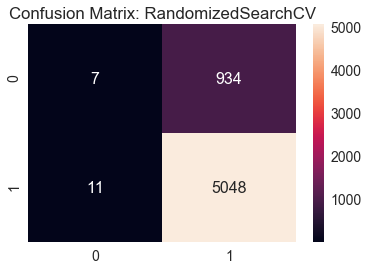

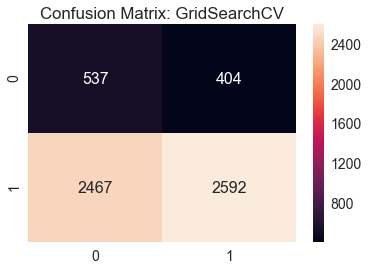

In [29]:
# W2V Main Function
# W2V Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features
# Can't find top n words using weight vector.

from sklearn.preprocessing import StandardScaler

# W2V Train
w2v_trainModel = trainW2V_model(X_train['CleanedText'].values)
X_train_vect = computeAvgW2V(w2v_trainModel, X_train['CleanedText'].values)

# W2V Test
w2v_testModel = trainW2V_model(X_test['CleanedText'].values)
X_test_vect = computeAvgW2V(w2v_testModel, X_test['CleanedText'].values)

# Standardisation. Set "with_mean=True" coz W2V vector is dense, not sparse
scaler = StandardScaler(copy=False).fit(X_train_vect)
X_train_vect = scaler.transform(X_train_vect)
scaler = StandardScaler(copy=False).fit(X_test_vect)
X_test_vect = scaler.transform(X_test_vect)

print(bold + "\n\n1) Grid Search and Random Search CV using Logistic Regression"+ end)

# Do both grid Search and Random Search. 
# The function returns optimal value of lambda
# Last parameter sets the maximum value of C for RandomCV
optimal_lambda, best_regularizer = gridRandomCV(X_train_vect, X_test_vect, 0.01)

# To check sparsity and f1 score for increasing values of lambda
# testL1_increaseLambda(X_train_vect, X_test_vect)

optimal_lambda = 0.00001
# Do pertubation test to check multicollinearity. 
# Get weight vector after removing collinear features.
# The last parameter denotes whether train vector is sparse or not
weights_non_collinear, mask = doPertubationTest(
                                X_train_vect, optimal_lambda, best_regularizer, False)

print("\nLength of Weight Vector (After Removing Collinearity): " 
                                      + str(len(weights_non_collinear)))

# print(w2v_trainModel.vocabulary)


# To print top n words
# find_top_words(count_vect, weights_non_collinear, mask, 20)



# TF-ID Weighted W2V

In [30]:
# average Word2Vec
# compute average word2vec for each review.

def compute_tfidW2V(w2v_model, model_tf_idf, count_vect, reviewText):

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0; 
    
    # TF-IDF weighted Word2Vec
    tfidf_feats = count_vect.get_feature_names() # tfidf words/col-names

    # iterate for each review/sentence
    for sent in reviewText: 
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()
        
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tfidf = model_tf_idf[row, tfidf_feats.index(word)]
                sent_vec += (vec * tfidf)
                weight_sum += tfidf
            except:
                pass
        sent_vec /= weight_sum

        tfidf_sent_vectors.append(sent_vec)
        row += 1

    return np.nan_to_num(tfidf_sent_vectors)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide




1) Grid Search and Random Search CV using Logistic Regression

Best Penalty: l1
RandomizedSearchCV: Best C: 0.9648400471483856  

Mean Test Score (+/-) Standard Deviation for Parameters: 
0.871 (+/-0.010) for {'C': 0.417022004702574, 'penalty': 'l1'}
0.876 (+/-0.013) for {'C': 0.9325573593386588, 'penalty': 'l2'}
0.872 (+/-0.011) for {'C': 0.30233257263183977, 'penalty': 'l2'}
0.871 (+/-0.010) for {'C': 0.23608897695197606, 'penalty': 'l2'}
0.870 (+/-0.010) for {'C': 0.1862602113776709, 'penalty': 'l2'}
0.876 (+/-0.011) for {'C': 0.66974603680348, 'penalty': 'l2'}
0.874 (+/-0.011) for {'C': 0.538816734003357, 'penalty': 'l1'}
0.870 (+/-0.010) for {'C': 0.3132735169322751, 'penalty': 'l1'}
0.867 (+/-0.008) for {'C': 0.20445224973151743, 'penalty': 'l1'}
0.868 (+/-0.008) for {'C': 0.22957721372982554, 'penalty': 'l1'}
0.876 (+/-0.011) for {'C': 0.6704675101784022, 'penalty': 'l2'}
0.874 (+/-0.011) for {'C': 0.45720480798698826, 'penalty': 'l2'}
0.865 (+/-0.010) for {'C': 0.140386938595

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


Distance between Weight vectors before & after Perturbation  = 12.02
Multicollinear Features = 136

Length of Weight Vector (After Removing Collinearity): 164


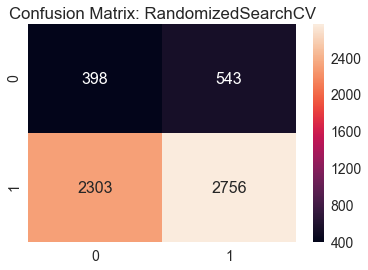

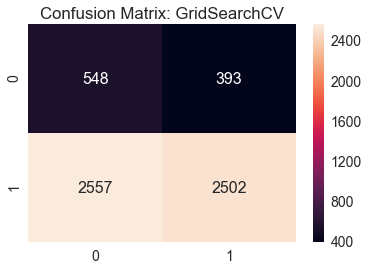

In [31]:
# tf-df weighted W2V Main Function
# tfidf and W2V Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features
# Can't find top n words using weight vector.

from sklearn.preprocessing import StandardScaler

# TFID
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
X_train_tfid_vect = count_vect.fit_transform(X_train['CleanedText'].values)

# TFID Test
X_test_tfid_vect = count_vect.transform(X_test['CleanedText'].values)


X_train_vect = compute_tfidW2V(w2v_trainModel, X_train_tfid_vect, 
                               count_vect, X_train['CleanedText'].values)
X_test_vect = compute_tfidW2V(w2v_testModel, X_test_tfid_vect, 
                              count_vect, X_test['CleanedText'].values)


# Standardisation. Set "with_mean=True" coz W2V vector is dense, not sparse
scaler = StandardScaler(copy=False).fit(X_train_vect)
X_train_vect = scaler.transform(X_train_vect)
scaler = StandardScaler(copy=False).fit(X_test_vect)
X_test_vect = scaler.transform(X_test_vect)

print(bold + "\n\n1) Grid Search and Random Search CV using Logistic Regression"+ end)

# Do both grid Search and Random Search. 
# The function returns optimal value of lambda
# sets the maximum value of C to be 10**4 for RandomCV
optimal_lambda, best_regularizer = gridRandomCV(X_train_vect, X_test_vect, 1)

# To check sparsity and f1 score for increasing values of lambda
# testL1_increaseLambda(X_train_vect, X_test_vect)

# Do pertubation test to check multicollinearity. 
# Get weight vector after removing collinear features.
weights_non_collinear, mask = doPertubationTest(
                                X_train_vect, optimal_lambda, best_regularizer, False)

print("\nLength of Weight Vector (After Removing Collinearity): " 
                                      + str(len(weights_non_collinear)))

# To print top n words
# find_top_words(count_vect, weights_non_collinear, mask, 20)


# Summary Statistics

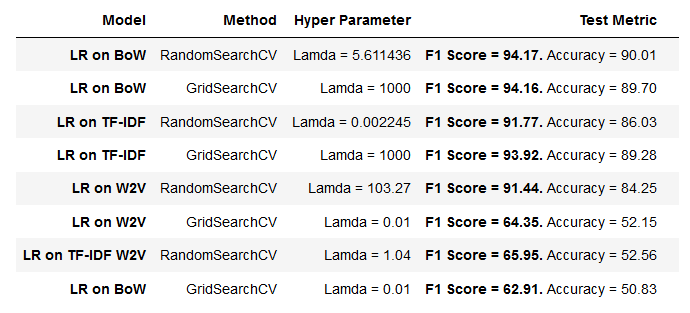

In [4]:
from IPython.display import Image
Image(filename='summary.png') 

# Observations

1) From the Sparsity and F1 Score plot, it can be identified that **Performance & Sparsity is the best when Log (Lambda) is between 1 and 2.** i.e. Lambda = 10^1 ~ 10^2 = 10 ~ 100. The lambda values obtained via plotting method is almost same as the lambda value found out by GridSearchCV and RandomSearchCV. (Please note that, **Sparsity = # of non-zero elements**, in this project).

2) It has also been noticed that, **with increasing lambda, the sparsity (# of non-zero elements) has been decreasing steadily.** This is an expected behaviour, as **L1 regularization** is used. 

3) The Lambda values found by GridSearchCV and RandomizedSearchCV are near, only when the range of "C" values is set within a narrow range, around optimum. i.e. if the optimal C = 1 (as per GridSearchCV), then by setting C as a uniform distribution between 0 and 4 will yield C = 1 (+/- 0.05) approximately, within say, 100 iterations. But if C value is set as a uniform distribution between 0 and say, 10000, then the error in C value is found to be very high.

4) Alternatively, **if the range of C value is wide, to arrive at optimal C, we need to increase the number of iterations** significantly. It is seen that, when iterations are increased from 100 to 1000, the C value is converging to optimum. But the **time complexity of such an approach would be much higher.**

5) Because of 3 and 4, it is suggested to **use GridSearchCV for faster convergence when the number of dimensions are less.** But, when the # of hyperparameters increase, the # of times the model needs to be trained, increases exponentially. If there are k hyperparameters, then m^k trainings would be required. Hence, **grid search is not good when hyperparameters are more.** In Logistic Regression, there could be only 2 hyperparameters. But there are cases in deep learning where there are 10s or 100s of hyper parameters.

6) **Random Search** is almost as good as Grid search, and also **faster than Grid search when # of hyper parameters is large.** But since the number of iterations required to find the optimal lambda for multiple dimensions is much more, more processing power may be required. Still, it would perform better than the exponential time requirement of Grid Search.

7) The elements of **W2V vector doesnt correspond to each word feature, like in the BoW vector or TF-ID vector.** Hence the weight vector w, that you get, which would be of the same length as W2V vector, once you fit logistic regression, doesnt correlate to word features. **Hence, we cannot find the top ‘n’ words when we use Word2Vec based featurization.** But we can still find the top ‘n’ features based on the weight vector, but that do not correspond to any word, hence not interpretable.

8) The best method is found to be **Logistic Regression on Bag of Words.** This method has the highest F1 Score, amongst all the 4 methods. Hence, Bag of Words featurization with Logistic Regression is the classifer of choice.